# Convolutional Neural Network (CNN)

- This Example demonstrates training a simple **Convolutional Neural Network(CNN)** to classify [CIFAR images](https://www.cs.toronto.edu/~kriz/cifar.html).
- The CIFAR10 dataset contains 60,000 color images in 10 classes, with 6,000 images in each class. The dataset is divided into 50,000 training images and 10,000 testing images. The classes are mutually exclusive and there is no overlap between them.


<img src="https://paperswithcode.com/media/datasets/CIFAR-10-0000000431-b71f61c0_U5n3Glr.jpg" width=70%>

## Download and prepare the CIFAR10 dataset

In [ ]:
from tensorflow.keras.datasets import cifar10

In [ ]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170508288/170498071 [==============================] - 4s 0us/step


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

In [ ]:
X_train.ndim

4

In [ ]:

X_train.shape

(40000, 32, 32, 3)

In [ ]:
X_train[0]

array([[[34, 36, 43],
        [37, 37, 51],
        [44, 44, 64],
        ...,
        [62, 73, 93],
        [52, 63, 83],
        [45, 57, 77]],

       [[35, 35, 37],
        [34, 34, 40],
        [34, 33, 43],
        ...,
        [58, 69, 89],
        [50, 60, 80],
        [47, 58, 78]],

       [[34, 33, 35],
        [33, 32, 36],
        [33, 32, 38],
        ...,
        [66, 77, 97],
        [51, 62, 82],
        [53, 64, 84]],

       ...,

       [[32, 32, 38],
        [32, 31, 37],
        [33, 33, 38],
        ...,
        [41, 38, 45],
        [34, 31, 38],
        [36, 32, 40]],

       [[33, 31, 36],
        [32, 30, 36],
        [34, 32, 37],
        ...,
        [37, 35, 40],
        [32, 29, 35],
        [30, 28, 33]],

       [[37, 32, 35],
        [37, 32, 36],
        [37, 33, 36],
        ...,
        [49, 47, 49],
        [47, 45, 48],
        [58, 56, 58]]], dtype=uint8)

In [ ]:
# For most image data, the pixel values are integers with values between 0 and 255
# Normalize pixel values to be between 0 and 1
# This can be achieved by dividing all pixels values by the largest pixel value; that is 255.
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

In [ ]:
y_train.ndim

2

In [ ]:
y_train.shape

(40000, 1)

In [ ]:
y_train

array([[6],
       [2],
       [5],
       ...,
       [8],
       [8],
       [8]], dtype=uint8)

In [ ]:
y_train = y_train.reshape(-1,)
y_val = y_val.reshape(-1,)
y_test = y_test.reshape(-1,)

In [ ]:
y_train

array([6, 2, 5, ..., 8, 8, 8], dtype=uint8)

## Verify the data

To verify that the dataset looks correct, let's plot some images from the training set and display the class name below each image.

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

def plot_sample(X, y, index):
    plt.figure(figsize = (15,2))
    plt.imshow(X[index])
    plt.xlabel(class_names[y[index]])
    plt.show()

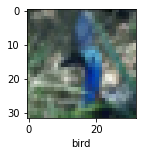

In [ ]:
plot_sample(X_train, y_train, 200)

## Convolutional Neural Network
<img src="https://miro.medium.com/max/2000/1*vkQ0hXDaQv57sALXAJquxA.jpeg">

### Create the convolutional base (Feature Extraction)

The 6 lines of code below define the convolutional base using a common pattern: a stack of [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) and [MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) layers.

As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size. If you are new to these dimensions, color_channels refers to (R,G,B). In this example, you will configure your CNN to process inputs of shape (32, 32, 3), which is the format of CIFAR images. You can do this by passing the argument `input_shape` to your first layer.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [ ]:
model = Sequential()

In [ ]:
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', input_shape = (32, 32, 3)))
model.add(MaxPooling2D((2, 2)))

In [ ]:
model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
model.add(MaxPooling2D((2, 2)))

Let's display the architecture of your model so far:

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
Total params: 19,392
Trainable params: 19,392
Non-trainable params: 0
_________________________________________________________________


Above, you can see that the output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). The width and height dimensions tend to shrink as you go deeper in the network. The number of output channels for each Conv2D layer is controlled by the first argument (e.g., 32 or 64). Typically,  as the width and height shrink, you can afford (computationally) to add more output channels in each Conv2D layer.

### Add Dense layers on top (Classification)

To complete the model, you will feed the last output tensor from the convolutional base (of shape (4, 4, 64)) into one or more Dense layers to perform classification. Dense layers take vectors as input (which are 1D), while the current output is a 3D tensor. First, you will flatten (or unroll) the 3D output to 1D,  then add one or more Dense layers on top. CIFAR has 10 output classes, so you use a final Dense layer with 10 outputs.

In [ ]:
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))

Here's the complete architecture of your model:

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dense (Dense)               (None, 64)                1

The network summary shows that (4, 4, 64) outputs were flattened into vectors of shape (1024) before going through two Dense layers.

## Compile and train the model

In [ ]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [ ]:
model.compile(optimizer='adam',
              loss= SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
%time history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1250/1250 [==============================] - 16s 4ms/step - loss: 1.4918 - accuracy: 0.4626 - val_loss: 1.2379 - val_accuracy: 0.5635
Epoch 2/20
1250/1250 [==============================] - 5s 4ms/step - loss: 1.1472 - accuracy: 0.5953 - val_loss: 1.0567 - val_accuracy: 0.6335
Epoch 3/20
1250/1250 [==============================] - 6s 5ms/step - loss: 1.0092 - accuracy: 0.6470 - val_loss: 1.0167 - val_accuracy: 0.6428
Epoch 4/20
1250/1250 [==============================] - 5s 4ms/step - loss: 0.9230 - accuracy: 0.6792 - val_loss: 0.9610 - val_accuracy: 0.6699
Epoch 5/20
1250/1250 [==============================] - 6s 5ms/step - loss: 0.8520 - accuracy: 0.7052 - val_loss: 0.9441 - val_accuracy: 0.6740
Epoch 6/20
1250/1250 [==============================] - 5s 4ms/step - loss: 0.7901 - accuracy: 0.7249 - val_loss: 1.0804 - val_accuracy: 0.6314
Epoch 7/20
1250/1250 [==============================] - 5s 4ms/step - loss: 0.7395 - accuracy: 0.7398 - val_loss: 0.9108 - val_accuracy: 0.6871
Ep

## Evaluate the model

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

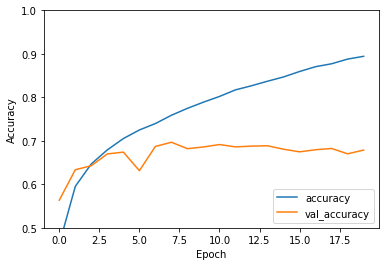

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [ ]:
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

313/313 - 1s - loss: 1.3979 - accuracy: 0.6788 - 703ms/epoch - 2ms/step


In [ ]:
print(test_acc)

0.6787999868392944
